In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import json
import numpy as np
import pickle as pickle_
import csv
import os
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [3]:
df = pd.read_csv("part6.csv")

In [6]:
data = df[['title','location']]

In [7]:
data.head()

,title,location
0,I'm so excited the road to #SuperBowlXLIX will...,#Seahawks #Mariners
1,At http://t.co/Vd0RWOeAed -- #Seahawks #12thMA...,NaN
2,You been 12ed pass it on #SeahawkNation #LOB #...,k-town Ak.
3,27 days to the SuperBowl 🏈🏈\n#Katyperry #KatyC...,Brazil
4,Check out the cool event that #budlight has p...,Iowa


In [9]:
print(data.shape)

(1348761, 2)


In [34]:
wash_list = ["seattle", "washington","wa","kirkland"]
not_wash = ["dc","d.c."]
mass_list = ["ma","massachusetts","boston","worcester","salem","plymouth","springfield","arlington","scituate","northampton"]
not_mass = ["ohio","oh"]

In [35]:
def check_wash(loc):
    flag = False
    locs = loc.lower().split()
    for word in wash_list:
        if word in locs:
            flag = True
            break
            
    for word in not_wash:
        if word in locs:
            flag = False
            break
    return flag

def check_mass(loc):
    flag = False
    locs = loc.lower().split()
    for word in mass_list:
        if word in locs:
            flag = True
            break
            
    for word in not_mass:
        if word in locs:
            flag = False
            break
    return flag

In [41]:
tweet=[]
location=[]
for i in range(0,data.shape[0]):
    str1 = str(data['location'][i])
    if check_wash(str1) == True :
        tweet.append(data['title'][i])
        location.append(0)
    elif check_mass(str1) == True :
        tweet.append(data['title'][i])
        location.append(1)

In [52]:
def tokenize(data):
    data = re.sub('[,.-:/()?{}*$#&]', ' ', data)
    # Convert list data to string
    raw = "".join(doc for doc in data)
    raw = "".join(ch for ch in raw if ord(ch) < 128)
    # Split into words
    tokens = word_tokenize(raw)
    # Convert to lower case
    tokens = [w.lower() for w in tokens]
    # Remove punctuation and keep on alphanumeric tokens
    punctuations = list(string.punctuation)
    punctuations.append("''")
    words = [word for word in tokens if word not in punctuations]
    words = [word for word in words if word.isalnum()]
    # Filter out stopwords
    stop_words = text.ENGLISH_STOP_WORDS
    words = [w for w in words if not w in stop_words]
    # Stemming
    stemmer = SnowballStemmer("english")
    stemmed = [stemmer.stem(word) for word in words]
    return stemmed  

In [68]:
def getLSI(df, X_train,X_test):
    print("Min df: ", df)
    vectorizer = CountVectorizer(analyzer="word", tokenizer=tokenize, min_df=df, stop_words="english")
    X_train_counts = vectorizer.fit_transform(X_train)
    tfidf_transformer = TfidfTransformer(smooth_idf=False)
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    print("Training Set TFIDF shape: ", X_train_tfidf.shape)
    X_test_counts = vectorizer.transform(X_test)
    X_test_tfidf = tfidf_transformer.transform(X_test_counts)
    print("Test Set TFIDF shape: ", X_test_tfidf.shape)
    svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
    svd_train = svd.fit_transform(X_train_tfidf)
    svd_test = svd.transform(X_test_tfidf)
    print("After SVD : ")
    print("Training Set TFIDF shape: ", svd_train.shape)
    print("Test Set TFIDF shape: ", svd_test.shape)
    print("------------------------")
    return svd_train, svd_test

In [67]:
def getNMF(df, X_train,X_test):
    print("\nMin df: ", df)
    vect = CountVectorizer(analyzer="word", tokenizer=tokenize, min_df=df, stop_words="english")
    X_train_counts = vect.fit_transform(X_train)
    X_test_counts = vect.transform(X_test)
    tfidf_transformer = TfidfTransformer(smooth_idf=False)
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    X_test_tfidf = tfidf_transformer.transform(X_test_counts)
    print("Training Set TFIDF shape: ", X_train_tfidf.shape)
    print("Test Set TFIDF shape: ", X_test_tfidf.shape)
    nmf = NMF(n_components=50, init='random', random_state=42)
    nmf_train = nmf.fit_transform(X_train_tfidf)
    nmf_test = nmf.transform(X_test_tfidf)
    print("After NMF : ")
    print("Training Set TFIDF shape: ", nmf_train.shape)
    print("Test Set TFIDF shape: ", nmf_test.shape)
    print("------------------------")
    return nmf_train, nmf_test

In [56]:
X_train, X_test, y_train, y_test = train_test_split(tweet, location, test_size=0.1, random_state=0)

In [69]:
svd_train_2,svd_test_2 = getLSI(2,X_train,X_test)
svd_train_5,svd_test_5 = getLSI(5,X_train,X_test)

Min df:  2
Training Set TFIDF shape:  (36539, 10410)
Test Set TFIDF shape:  (4060, 10410)
After SVD : 
Training Set TFIDF shape:  (36539, 50)
Test Set TFIDF shape:  (4060, 50)
------------------------
Min df:  5
Training Set TFIDF shape:  (36539, 4729)
Test Set TFIDF shape:  (4060, 4729)
After SVD : 
Training Set TFIDF shape:  (36539, 50)
Test Set TFIDF shape:  (4060, 50)
------------------------


In [70]:
nmf_train_2,nmf_test_2 = getNMF(2,X_train,X_test)
nmf_train_5,nmf_test_5 = getNMF(5,X_train,X_test)


Min df:  2
Training Set TFIDF shape:  (36539, 10410)
Test Set TFIDF shape:  (4060, 10410)
After NMF : 
Training Set TFIDF shape:  (36539, 50)
Test Set TFIDF shape:  (4060, 50)
------------------------

Min df:  5
Training Set TFIDF shape:  (36539, 4729)
Test Set TFIDF shape:  (4060, 4729)
After NMF : 
Training Set TFIDF shape:  (36539, 50)
Test Set TFIDF shape:  (4060, 50)
------------------------


In [73]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
def performance_metrics(y_pred, y_test, y_score, categories=["Washington", "Massachusetts"], normalization=True):
    print("Precision Score: ", precision_score(y_test, y_pred))
    print("Recall Score: ", recall_score(y_test, y_pred))
    print("Accuracy Score: ", accuracy_score(y_test, y_pred))
    plot_confusion_matrix(confusion_matrix(y_test, y_pred), categories, normalization)
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plot_roc_curve(fpr,tpr, roc_auc)

### SVM Classifier

In [87]:
def perform_SVM(title,X_train,y_train,X_test,y_test):
    print(title)
    parameters = {'C':[0.0001,0.001,0.01,0.1,1,10,100,1000]}
    clf = GridSearchCV(LinearSVC(), parameters, cv=5)
    clf.fit(X_train,y_train)
    print("Best Parameter : ",clf.best_params_)
    best_param = list(clf.best_params_.values())[0]
    svc = LinearSVC(C=best_param)
    svc.fit(X_train,y_train)
    preds = svc.predict(X_test)
    y_score = svc.decision_function(X_test)
    performance_metrics(preds,y_test,y_score)

LSI with Min df = 2
Best Parameter :  {'C': 10}
Precision Score:  0.729070999647
Recall Score:  0.952908587258
Accuracy Score:  0.785960591133
Normalized confusion matrix
[[ 0.59503696  0.40496304]
 [ 0.04709141  0.95290859]]


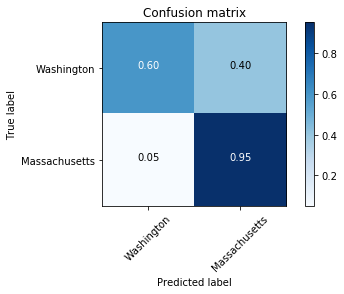

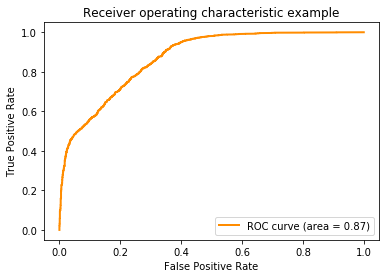

LSI with Min df = 5
Best Parameter :  {'C': 10}
Precision Score:  0.729262266149
Recall Score:  0.953831948292
Accuracy Score:  0.78645320197
Normalized confusion matrix
[[ 0.59503696  0.40496304]
 [ 0.04616805  0.95383195]]


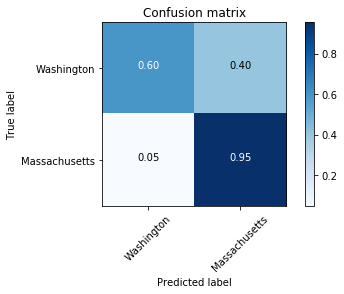

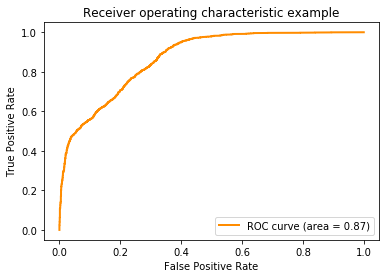

NMF with Min df = 2
Best Parameter :  {'C': 1}
Precision Score:  0.728138222849
Recall Score:  0.953370267775
Accuracy Score:  0.785221674877
Normalized confusion matrix
[[ 0.59292503  0.40707497]
 [ 0.04662973  0.95337027]]


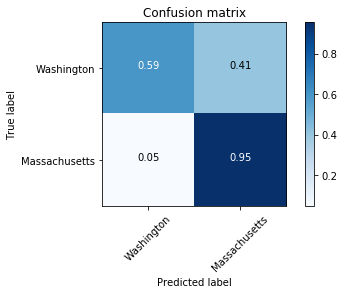

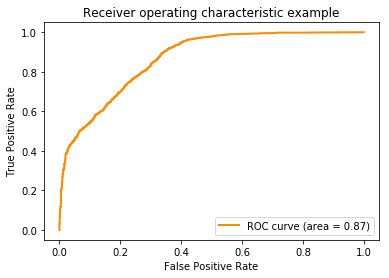

NMF with Min df = 5
Best Parameter :  {'C': 100}
Precision Score:  0.72762508809
Recall Score:  0.953370267775
Accuracy Score:  0.784729064039
Normalized confusion matrix
[[ 0.59186906  0.40813094]
 [ 0.04662973  0.95337027]]


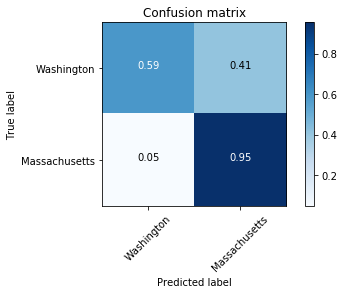

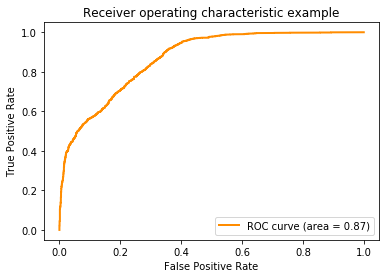

In [86]:
perform_SVM("LSI with Min df = 2",svd_train_2,y_train,svd_test_2,y_test)
perform_SVM("LSI with Min df = 5",svd_train_5,y_train,svd_test_5,y_test)
perform_SVM("NMF with Min df = 2",nmf_train_2,y_train,nmf_test_2,y_test)
perform_SVM("NMF with Min df = 5",nmf_train_5,y_train,nmf_test_5,y_test)

### Logistic Regression

#### L1 Norm

In [95]:
def perform_LR(title,X_train,y_train,X_test,y_test,penalty_):
    print(title)
    parameters = {'C':[0.001,0.01,0.1,1,10,100,1000]}
    clf = GridSearchCV(LogisticRegression(penalty=penalty_), parameters, cv=5)
    clf.fit(X_train,y_train)
    print("Best Parameter : ",clf.best_params_)
    best_param = list(clf.best_params_.values())[0]
    lr = LogisticRegression(penalty=penalty_,C=best_param)
    lr.fit(X_train,y_train)
    preds = lr.predict(X_test)
    y_score = lr.predict_proba(X_test)
    performance_metrics(preds,y_test,y_score[:,1])

LSI with Min df = 2
Best Parameter :  {'C': 100}
Precision Score:  0.732504440497
Recall Score:  0.951985226223
Accuracy Score:  0.788916256158
Normalized confusion matrix
[[ 0.60242872  0.39757128]
 [ 0.04801477  0.95198523]]


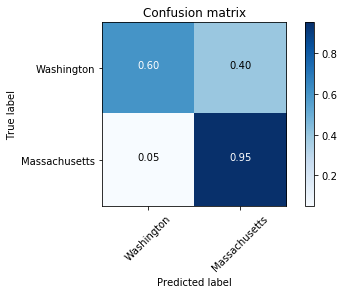

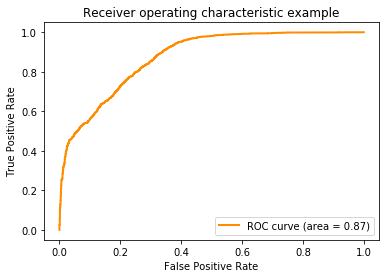

LSI with Min df = 5
Best Parameter :  {'C': 1}
Precision Score:  0.732174529975
Recall Score:  0.952908587258
Accuracy Score:  0.788916256158
Normalized confusion matrix
[[ 0.60137276  0.39862724]
 [ 0.04709141  0.95290859]]


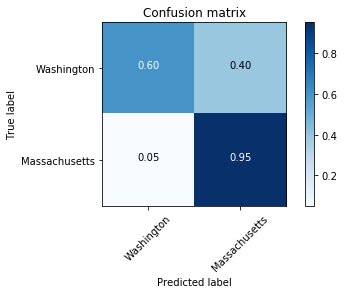

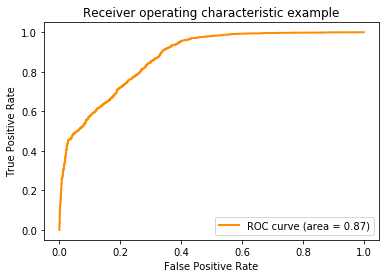

NMF with Min df = 2
Best Parameter :  {'C': 1}
Precision Score:  0.730536793459
Recall Score:  0.948753462604
Accuracy Score:  0.785960591133
Normalized confusion matrix
[[ 0.59978881  0.40021119]
 [ 0.05124654  0.94875346]]


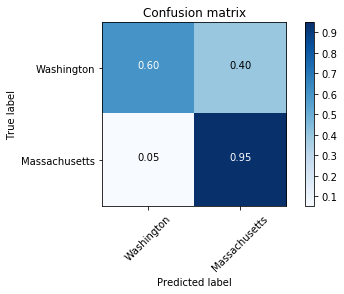

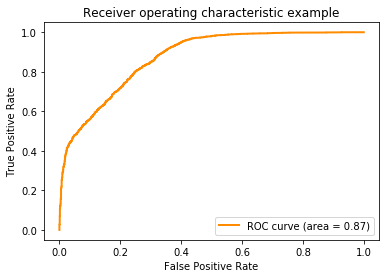

NMF with Min df = 5
Best Parameter :  {'C': 10}
Precision Score:  0.730987917555
Recall Score:  0.949676823638
Accuracy Score:  0.786699507389
Normalized confusion matrix
[[ 0.60031679  0.39968321]
 [ 0.05032318  0.94967682]]


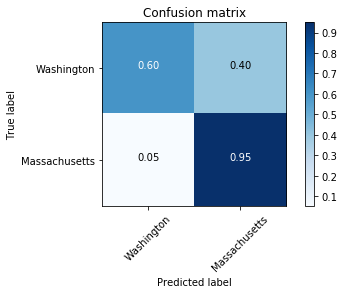

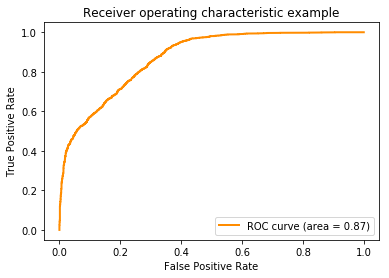

In [96]:
perform_LR("LSI with Min df = 2",svd_train_2,y_train,svd_test_2,y_test,'l1')
perform_LR("LSI with Min df = 5",svd_train_5,y_train,svd_test_5,y_test,'l1')
perform_LR("NMF with Min df = 2",nmf_train_2,y_train,nmf_test_2,y_test,'l1')
perform_LR("NMF with Min df = 5",nmf_train_5,y_train,nmf_test_5,y_test,'l1')

#### L2 Norm

LSI with Min df = 2
Best Parameter :  {'C': 100}
Precision Score:  0.732244318182
Recall Score:  0.951985226223
Accuracy Score:  0.788669950739
Normalized confusion matrix
[[ 0.60190074  0.39809926]
 [ 0.04801477  0.95198523]]


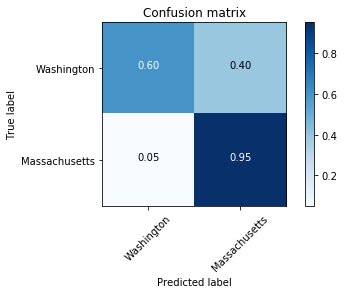

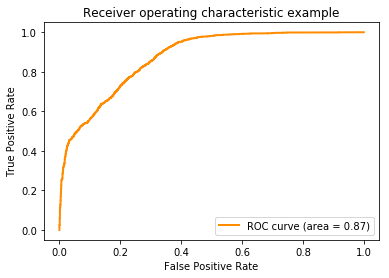

LSI with Min df = 5
Best Parameter :  {'C': 1000}
Precision Score:  0.732504440497
Recall Score:  0.951985226223
Accuracy Score:  0.788916256158
Normalized confusion matrix
[[ 0.60242872  0.39757128]
 [ 0.04801477  0.95198523]]


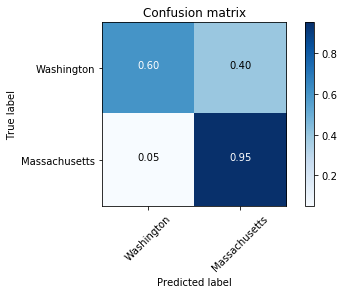

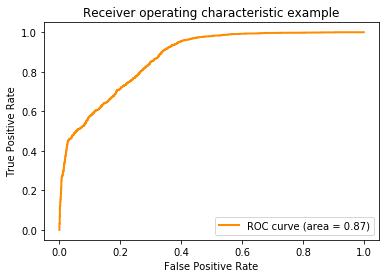

NMF with Min df = 2
Best Parameter :  {'C': 10}
Precision Score:  0.730823863636
Recall Score:  0.950138504155
Accuracy Score:  0.786699507389
Normalized confusion matrix
[[ 0.59978881  0.40021119]
 [ 0.0498615   0.9501385 ]]


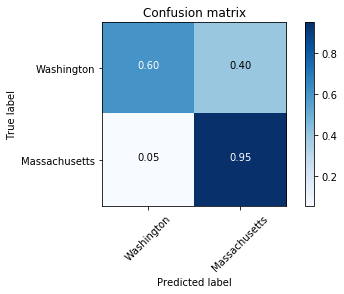

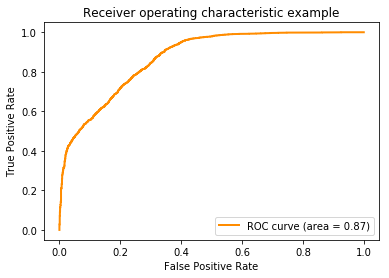

NMF with Min df = 5
Best Parameter :  {'C': 100}
Precision Score:  0.730987917555
Recall Score:  0.949676823638
Accuracy Score:  0.786699507389
Normalized confusion matrix
[[ 0.60031679  0.39968321]
 [ 0.05032318  0.94967682]]


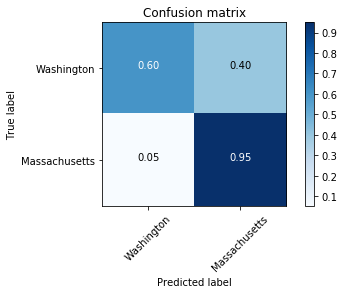

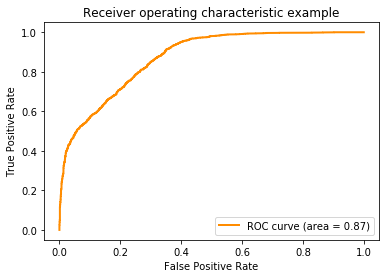

In [97]:
perform_LR("LSI with Min df = 2",svd_train_2,y_train,svd_test_2,y_test,'l2')
perform_LR("LSI with Min df = 5",svd_train_5,y_train,svd_test_5,y_test,'l2')
perform_LR("NMF with Min df = 2",nmf_train_2,y_train,nmf_test_2,y_test,'l2')
perform_LR("NMF with Min df = 5",nmf_train_5,y_train,nmf_test_5,y_test,'l2')

### Random Forest Classifier

In [103]:
def perform_RF(title,X_train,y_train,X_test,y_test):
    print(title)
    parameters = {'n_estimators':[10,20,30,40,50]}
    clf = GridSearchCV(RandomForestClassifier(), parameters, cv=5)
    clf.fit(X_train,y_train)
    print("Best Parameter : ",clf.best_params_)
    best_param = list(clf.best_params_.values())[0]
    rf = RandomForestClassifier(n_estimators=best_param)
    rf.fit(X_train,y_train)
    preds = rf.predict(X_test)
    y_score = rf.predict_proba(X_test)
    performance_metrics(preds,y_test,y_score[:,1])

LSI with Min df = 2
Best Parameter :  {'n_estimators': 50}
Precision Score:  0.754940711462
Recall Score:  0.881809787627
Accuracy Score:  0.784236453202
Normalized confusion matrix
[[ 0.67265048  0.32734952]
 [ 0.11819021  0.88180979]]


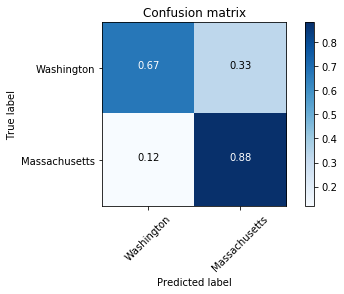

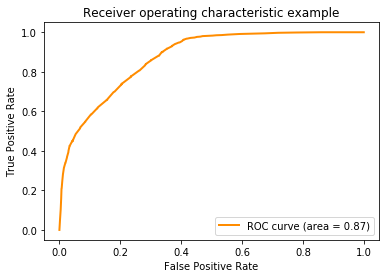

LSI with Min df = 5
Best Parameter :  {'n_estimators': 50}
Precision Score:  0.761662093297
Recall Score:  0.897045244691
Accuracy Score:  0.795320197044
Normalized confusion matrix
[[ 0.67898627  0.32101373]
 [ 0.10295476  0.89704524]]


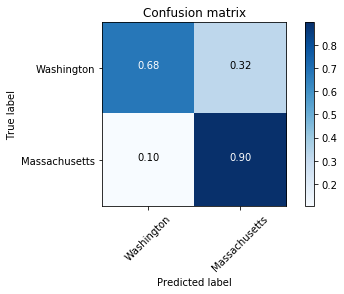

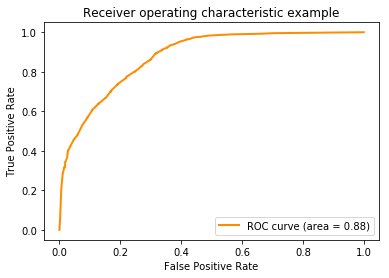

NMF with Min df = 2
Best Parameter :  {'n_estimators': 50}
Precision Score:  0.764243614931
Recall Score:  0.897968605725
Accuracy Score:  0.797783251232
Normalized confusion matrix
[[ 0.68321014  0.31678986]
 [ 0.10203139  0.89796861]]


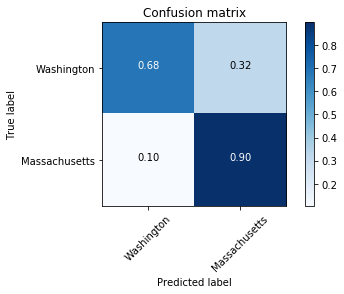

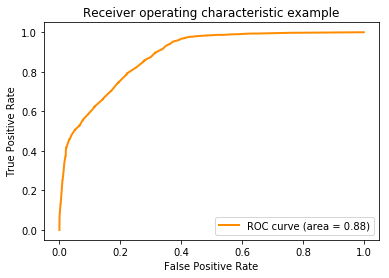

NMF with Min df = 5
Best Parameter :  {'n_estimators': 50}
Precision Score:  0.767009493671
Recall Score:  0.895198522622
Accuracy Score:  0.799014778325
Normalized confusion matrix
[[ 0.68901795  0.31098205]
 [ 0.10480148  0.89519852]]


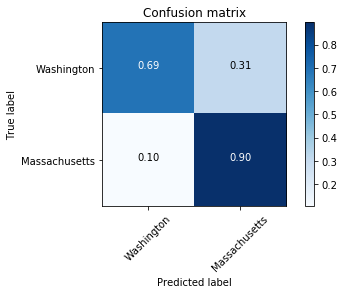

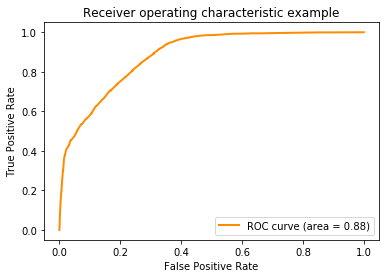

In [104]:
perform_RF("LSI with Min df = 2",svd_train_2,y_train,svd_test_2,y_test)
perform_RF("LSI with Min df = 5",svd_train_5,y_train,svd_test_5,y_test)
perform_RF("NMF with Min df = 2",nmf_train_2,y_train,nmf_test_2,y_test)
perform_RF("NMF with Min df = 5",nmf_train_5,y_train,nmf_test_5,y_test)

### Neural Network Classifier

In [111]:
def perform_NN(title,X_train,y_train,X_test,y_test):
    print(title)
    parameters = {'activation' : ['identity', 'logistic', 'tanh', 'relu']}
    clf = GridSearchCV(MLPClassifier(), parameters, cv=5)
    clf.fit(X_train,y_train)
    print("Best Parameter : ",clf.best_params_)
    best_param = list(clf.best_params_.values())[0]
    mlp = MLPClassifier(activation=best_param)
    mlp.fit(X_train,y_train)
    preds = mlp.predict(X_test)
    y_score = mlp.predict_proba(X_test)
    performance_metrics(preds,y_test,y_score[:,1])

LSI with Min df = 2
Best Parameter :  {'activation': 'relu'}
Precision Score:  0.753898820844
Recall Score:  0.915050784857
Accuracy Score:  0.795320197044
Normalized confusion matrix
[[ 0.65839493  0.34160507]
 [ 0.08494922  0.91505078]]


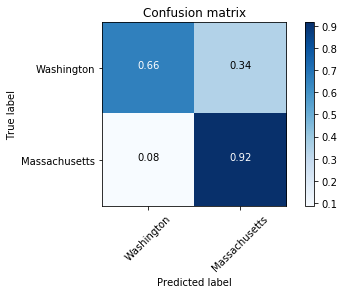

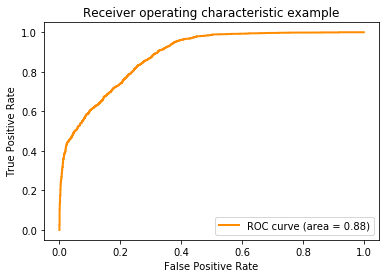

LSI with Min df = 5
Best Parameter :  {'activation': 'relu'}
Precision Score:  0.745967741935
Recall Score:  0.939519852262
Accuracy Score:  0.797044334975
Normalized confusion matrix
[[ 0.63410771  0.36589229]
 [ 0.06048015  0.93951985]]


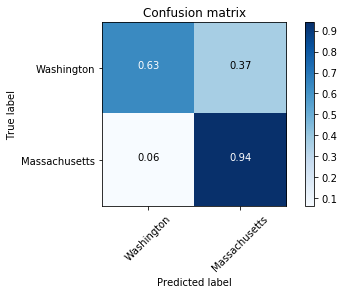

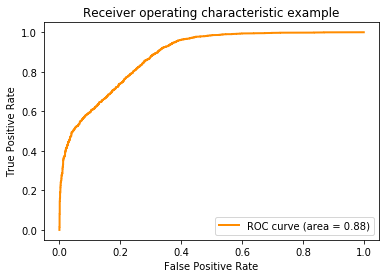

NMF with Min df = 2
Best Parameter :  {'activation': 'relu'}
Precision Score:  0.745694393551
Recall Score:  0.939519852262
Accuracy Score:  0.796798029557
Normalized confusion matrix
[[ 0.63357973  0.36642027]
 [ 0.06048015  0.93951985]]


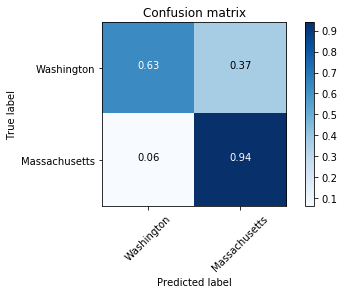

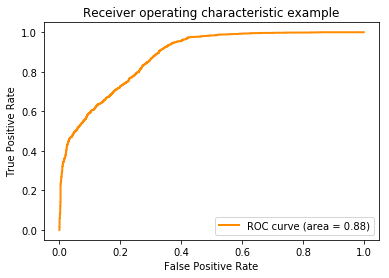

NMF with Min df = 5
Best Parameter :  {'activation': 'relu'}
Precision Score:  0.751978891821
Recall Score:  0.921052631579
Accuracy Score:  0.795812807882
Normalized confusion matrix
[[ 0.65258712  0.34741288]
 [ 0.07894737  0.92105263]]


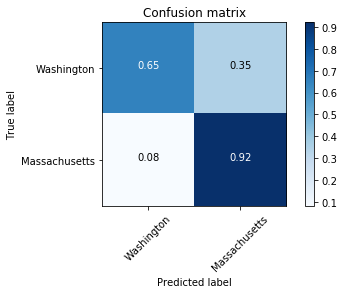

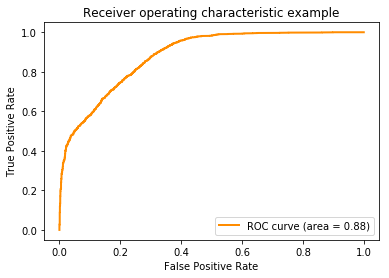

In [112]:
perform_NN("LSI with Min df = 2",svd_train_2,y_train,svd_test_2,y_test)
perform_NN("LSI with Min df = 5",svd_train_5,y_train,svd_test_5,y_test)
perform_NN("NMF with Min df = 2",nmf_train_2,y_train,nmf_test_2,y_test)
perform_NN("NMF with Min df = 5",nmf_train_5,y_train,nmf_test_5,y_test)